In [1]:
import sys
import os
import random
import math
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
import numpy as np

In [2]:
from PIL import Image

In [3]:
loaded = torch.load('block.pth')
data = loaded["dataset"]
labels = loaded["labels"]
images = loaded["images"]
size = len(data)

In [34]:
images

['n02951358_31190',
 'n03452741_16744',
 'n04069434_10318',
 'n02951358_34807',
 'n03452741_5499',
 'n03376595_247',
 'n02906734_14010',
 'n03452741_2982',
 'n02607072_5873',
 'n02510455_96034',
 'n02281787_4182',
 'n02906734_508',
 'n03272010_4472',
 'n04044716_691',
 'n03272562_1177',
 'n03773504_14125',
 'n02607072_3895',
 'n03272010_6902',
 'n03709823_451',
 'n02389026_2743',
 'n04044716_8814',
 'n03197337_1807',
 'n03773504_2986',
 'n03709823_25676',
 'n02124075_9271',
 'n02389026_27266',
 'n03180011_9576',
 'n03197337_1925',
 'n02281787_4713',
 'n02492035_1742',
 'n03773504_6291',
 'n02951358_4819',
 'n03272562_4339',
 'n02124075_4538',
 'n04086273_29346',
 'n03792782_1424',
 'n03877472_53538',
 'n03773504_2899',
 'n03888257_5543',
 'n03775071_11195',
 'n03452741_3088',
 'n02504458_7221',
 'n03272562_2929',
 'n07873807_6649',
 'n11939491_8940',
 'n02106662_2328',
 'n02906734_6563',
 'n03376595_5336',
 'n03775071_4141',
 'n03297495_7249',
 'n04120489_4154',
 'n03197337_544',
 'n02

In [38]:
data[0]

{'eeg': tensor([[ 0.0000e+00,  0.0000e+00,  2.0000e+00,  ..., -3.7000e+01,
          -3.9000e+01, -3.8000e+01],
         [-1.2000e+01, -1.1000e+01, -8.0000e+00,  ..., -2.6000e+01,
          -3.0000e+01, -3.3000e+01],
         [ 3.5000e+01,  2.9000e+01,  2.1000e+01,  ..., -1.7000e+01,
          -1.2000e+01, -9.0000e+00],
         ...,
         [-8.3000e+02, -8.2600e+02, -8.3800e+02,  ..., -9.3500e+02,
          -9.5600e+02, -1.0280e+03],
         [-7.8200e+02, -8.4800e+02, -8.4000e+02,  ..., -9.5100e+02,
          -9.8700e+02, -9.9400e+02],
         [-2.6560e+03, -2.6430e+03, -2.6160e+03,  ..., -2.7470e+03,
          -2.7790e+03, -2.7860e+03]]), 'image': 0, 'label': 10, 'subject': 4}

In [39]:
print(labels[data[0]["label"]],images[0])

n02951358 n02951358_31190


In [27]:
maxi = -1
count = 0
for d in data:
    eeg = d['eeg']
    maxi = max(eeg.shape[1],maxi)
    if(eeg.shape[1]>500):
        count+=1
print(maxi,count)

1527 7876


In [3]:
BASE_DIR = os.path.join('ImageNet','imagesNew','ILSVRC2012_img_train')
print(BASE_DIR)

ImageNet/imagesNew/ILSVRC2012_img_train


In [4]:
import pandas as pd

In [40]:
images_path = []
exists = []
for row in data:
    image_path = os.path.join(BASE_DIR,labels[row['label']],images[row['image']]+'.JPEG')
    images_path.append(image_path)
    exists.append(os.path.exists(image_path))

In [41]:
not_present = []
for i in range(len(exists)):
    if not exists[i]:
        not_present.append(images_path[i])     

In [42]:
not_present

[]

In [43]:
len(not_present)

0

In [47]:
class EEGDataset:
    def __init__(self, eeg_signals_path):
        loaded = torch.load(eeg_signals_path)
        self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.size = len(self.data)
        self.BASE_DIR = os.path.join('ImageNet','imagesNew','ILSVRC2012_img_train')
    def __len__(self):
        return self.size
    def __getitem__(self, i):
        # Process EEG
        eeg = self.data[i]["eeg"].float()
        eeg = ((self.data[i]["eeg"].float() - self.data[i]["eeg"].mean())/self.data[i]["eeg"].std())
        eeg = eeg.t()
#         print(eeg.shape)
        eeg = eeg[20:450,:]
        # Get label
        label = self.data[i]["label"]
        img_name = self.data[i]["image"]
        image_path = os.path.join(self.BASE_DIR,self.labels[label],self.images[img_name]+'.JPEG')
        img = Image.open(image_path)
        # Return
        return eeg, label,img

In [48]:
dataset = EEGDataset('block.pth')

In [51]:
labels[dataset[100][1]]

'n02690373'

In [52]:
dataset[100][2].show()

In [5]:
file = open('eeg_classification_Verbose.txt','r')

In [6]:
data = []
for line in file.readlines():
    x = line.split(':')[1].strip().split(',')
    data.append(x)
    

In [7]:
len(data)

104

In [8]:
data

[['TrL=3.4850',
  ' TrA=0.0513',
  ' VL=3.1493',
  ' VA=0.0847',
  ' TeL=3.2026',
  ' TeA=0.0776'],
 ['TrL=3.1273',
  ' TrA=0.0944',
  ' VL=3.0883',
  ' VA=0.0958',
  ' TeL=3.0946',
  ' TeA=0.1053'],
 ['TrL=2.8559',
  ' TrA=0.1249',
  ' VL=2.7241',
  ' VA=0.1190',
  ' TeL=2.7289',
  ' TeA=0.1295'],
 ['TrL=2.5397',
  ' TrA=0.1706',
  ' VL=2.5098',
  ' VA=0.1613',
  ' TeL=2.5101',
  ' TeA=0.1683'],
 ['TrL=2.5999',
  ' TrA=0.1801',
  ' VL=2.8164',
  ' VA=0.1759',
  ' TeL=2.8640',
  ' TeA=0.1754'],
 ['TrL=2.3420',
  ' TrA=0.2208',
  ' VL=2.2093',
  ' VA=0.2344',
  ' TeL=2.2106',
  ' TeA=0.2525'],
 ['TrL=2.1802',
  ' TrA=0.2434',
  ' VL=2.1292',
  ' VA=0.2389',
  ' TeL=2.1541',
  ' TeA=0.2293'],
 ['TrL=2.0365',
  ' TrA=0.2767',
  ' VL=2.0544',
  ' VA=0.2651',
  ' TeL=2.0836',
  ' TeA=0.2772'],
 ['TrL=2.0974',
  ' TrA=0.2781',
  ' VL=2.0231',
  ' VA=0.2646',
  ' TeL=2.0393',
  ' TeA=0.2818'],
 ['TrL=1.9780',
  ' TrA=0.3093',
  ' VL=1.9023',
  ' VA=0.2944',
  ' TeL=1.8911',
  ' TeA=0.3070'],


In [9]:
trainLoss = []
trainAccuracy = []

valLoss = []
valAccuracy = []

testLoss = []
testAccuracy = []
for d in data:
    trainLoss.append(float(d[0].strip().split('=')[1]))
    trainAccuracy.append(float(d[1].strip().split('=')[1]))
    
    valLoss.append(float(d[2].strip().split('=')[1]))
    valAccuracy.append(float(d[3].strip().split('=')[1]))
    
    testLoss.append(float(d[4].strip().split('=')[1]))
    testAccuracy.append(float(d[5].strip().split('=')[1]))

In [10]:
csvF = pd.DataFrame({'trainLoss':trainLoss,
                    'trainAccuracy':trainAccuracy,
                    'valLoss':valLoss,
                    'valAccuracy':valAccuracy,
                    'testLoss':testLoss,
                    'testAccuracy':testAccuracy})

In [24]:
csvF.to_csv('eeg_classification_training_history.csv',index=False)

In [11]:
import matplotlib.pyplot as plt

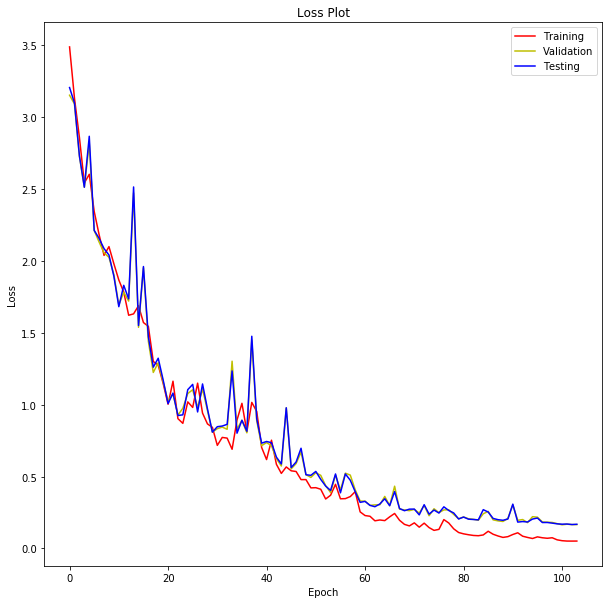

In [12]:
plt.figure(figsize=(10,10))
plt.plot(trainLoss,'r')
plt.plot(valLoss,'y')
plt.plot(testLoss,'b')
plt.legend(['Training','Validation','Testing'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

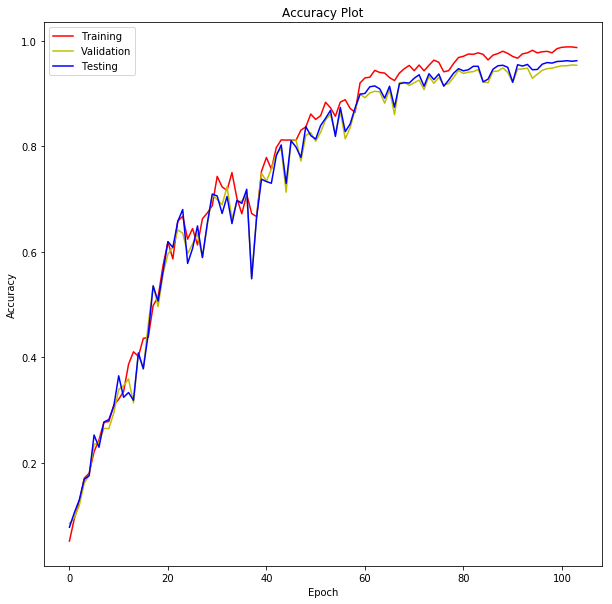

In [13]:
plt.figure(figsize=(10,10))
plt.plot(trainAccuracy,'r')
plt.plot(valAccuracy,'y')
plt.plot(testAccuracy,'b')
plt.legend(['Training','Validation','Testing'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [47]:
a = np.random.normal(0.5,0.5,(154,))
b = np.random.normal(0.5,0.5,(154,))
c = np.random.normal(0.5,0.5,(154,))

In [48]:
a = sorted(a)
a = a[:104]
a = a-min(a)
a /=max(a)

b = sorted(b)
b = b[:104]
b -=min(b)
b /=max(b)

c = sorted(c)
c = c[:104]
c = c-min(c)
c /=max(c)

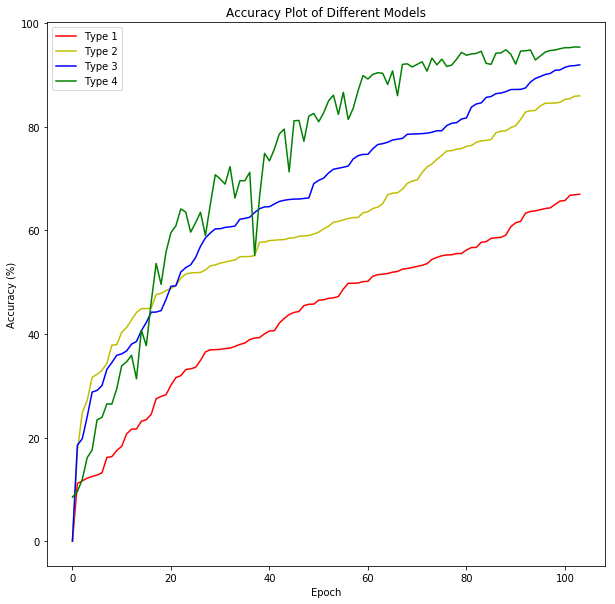

In [58]:
plt.figure(figsize=(10,10))
plt.plot(a*67,c='r')
plt.plot(b*86,c='y')
plt.plot(c*92,c='b')
plt.plot(np.array(valAccuracy)*100,c='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Plot of Different Models')
plt.legend(['Type 1','Type 2','Type 3','Type 4'])
plt.show()
